# Курсовая работа
## Датасет: [Messy vs Clean Room](https://www.kaggle.com/datasets/cdawn1/messy-vs-clean-room)
### Выполнил Попов Матвей, группа М8О-114СВ-24


## О датасете

Используется для задач распознавания степени убранности комнаты. Содержит 212 
изображений комнат, которые распределены на 2 категории:

* Messy (беспорядок)
* Tidy (порядок)

Каждое изображение цветное, разрешение 299x299 пикселей. Датасет представлен в 
виде архива изображений, для каждого класса представлена своя директория.


## Обучение модели-классификатора изображений


Подкючаем необходимые импорты

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


Загружаем датасет

In [50]:
!curl -L -o messy-vs-clean-room.zip https://www.kaggle.com/api/v1/datasets/download/cdawn1/messy-vs-clean-room

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  0      0 --:--:-- --:--:-- --:--:--     0
100 67.1M  100 67.1M    0     0  7152k      0  0:00:09  0:00:09 --:--:-- 6938k


In [51]:
!unzip messy-vs-clean-room.zip -d dataset

Archive:  messy-vs-clean-room.zip
  inflating: dataset/images/images/test/0.png  
  inflating: dataset/images/images/test/1.png  
  inflating: dataset/images/images/test/2.png  
  inflating: dataset/images/images/test/3.png  
  inflating: dataset/images/images/test/4.png  
  inflating: dataset/images/images/test/5.png  
  inflating: dataset/images/images/test/6.png  
  inflating: dataset/images/images/test/7.png  
  inflating: dataset/images/images/test/8.png  
  inflating: dataset/images/images/test/9.png  
  inflating: dataset/images/images/train/clean/0.png  
  inflating: dataset/images/images/train/clean/1.png  
  inflating: dataset/images/images/train/clean/10.png  
  inflating: dataset/images/images/train/clean/11.png  
  inflating: dataset/images/images/train/clean/12.png  
  inflating: dataset/images/images/train/clean/13.png  
  inflating: dataset/images/images/train/clean/14.png  
  inflating: dataset/images/images/train/clean/15.png  
  inflating: dataset/images/images/train

In [4]:
cudnn.benchmark = True
plt.ion()

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './dataset/images/images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Выведем структуру датасета

In [5]:
dataset_sizes

{'train': 192, 'val': 20}

In [6]:
class_names

['clean', 'messy']

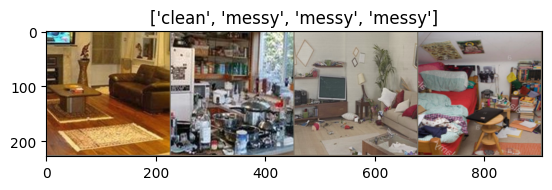

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


### Обучение модели

Используем предобученную модель ResNet-18


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5941 Acc: 0.6771
val Loss: 0.1677 Acc: 0.9000

Epoch 1/24
----------
train Loss: 0.4556 Acc: 0.7969
val Loss: 0.0721 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.5961 Acc: 0.7812
val Loss: 0.0590 Acc: 0.9500

Epoch 3/24
----------
train Loss: 0.3586 Acc: 0.8750
val Loss: 0.1834 Acc: 0.9000

Epoch 4/24
----------
train Loss: 0.6817 Acc: 0.7656
val Loss: 0.0100 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.5478 Acc: 0.8177
val Loss: 0.2255 Acc: 0.9500

Epoch 6/24
----------
train Loss: 0.6869 Acc: 0.7500
val Loss: 0.2500 Acc: 0.9500

Epoch 7/24
----------
train Loss: 0.3327 Acc: 0.8594
val Loss: 0.0492 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.3615 Acc: 0.8698
val Loss: 0.0706 Acc: 0.9500

Epoch 9/24
----------
train Loss: 0.2349 Acc: 0.8906
val Loss: 0.1006 Acc: 0.9500

Epoch 10/24
----------
train Loss: 0.2317 Acc: 0.9167
val Loss: 0.1072 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.1838 Acc: 0.9479
val Loss: 0.0703 Acc: 0.9500

Ep

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5865 Acc: 0.6979
val Loss: 0.3834 Acc: 0.8000

Epoch 1/24
----------
train Loss: 0.5408 Acc: 0.7344
val Loss: 0.3360 Acc: 0.8500

Epoch 2/24
----------
train Loss: 0.4629 Acc: 0.8021
val Loss: 0.2278 Acc: 0.8500

Epoch 3/24
----------
train Loss: 0.4830 Acc: 0.7969
val Loss: 0.2622 Acc: 0.9000

Epoch 4/24
----------
train Loss: 0.6891 Acc: 0.7448
val Loss: 0.3096 Acc: 0.8500

Epoch 5/24
----------
train Loss: 0.3000 Acc: 0.8646
val Loss: 0.2450 Acc: 0.8500

Epoch 6/24
----------
train Loss: 0.4026 Acc: 0.8281
val Loss: 0.2506 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.4079 Acc: 0.8333
val Loss: 0.1905 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.2946 Acc: 0.8698
val Loss: 0.2046 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.3540 Acc: 0.8438
val Loss: 0.2419 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.2940 Acc: 0.8646
val Loss: 0.1604 Acc: 0.8500

Epoch 11/24
----------
train Loss: 0.3876 Acc: 0.8698
val Loss: 0.1680 Acc: 0.9500

Ep

### Примеры использования модели

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


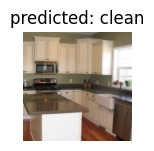

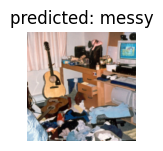

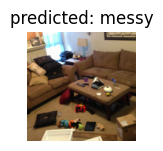

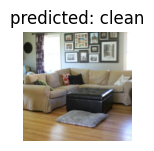

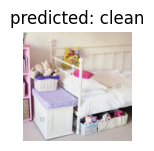

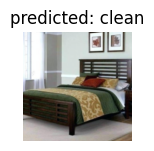

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()


In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


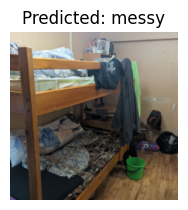

In [17]:
visualize_model_predictions(
    model_conv,
    img_path='./img/example.jpg'
)

plt.ioff()
plt.show()


## Выделение признаков классификации

Используем алгоритм LIME


In [48]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def transform_image_for_model(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = data_transforms['val'](img)
    return img_tensor.unsqueeze(0).to(device)

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor.cpu() * std + mean

def batch_predict(images):
    model_conv.eval()
    batch = torch.stack([data_transforms['val'](Image.fromarray(img)).to(device) for img in images], dim=0)
    with torch.no_grad():
        logits = model_conv(batch)
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

def explain_prediction_with_lime(img_path):
    img = Image.open(img_path).convert('RGB').resize((256, 256))
    np_img = np.array(img)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np_img,
        batch_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=3,
        min_weight=0.0
    )

    plt.figure(figsize=(6, 6))
    plt.title(f"Predicted: {class_names[explanation.top_labels[0]]}")
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis('off')
    plt.show()


100%|██████████| 1000/1000 [00:13<00:00, 72.80it/s]


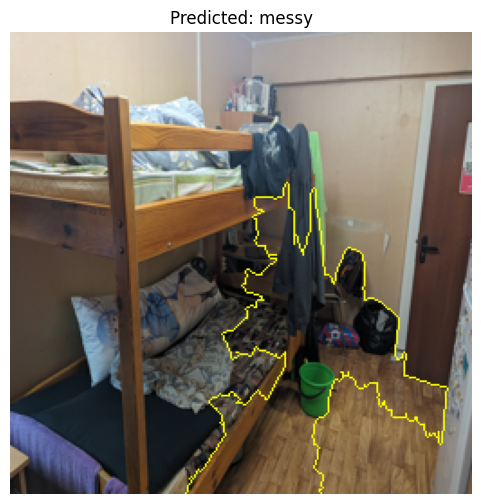

In [49]:
explain_prediction_with_lime("./img/example.jpg")


## Вывод

Дообучил предобученную нейронную сеть, чтобы она смогла определять, является ли 
комната убранной или неубранной. Чтобы проверить ее на работоспособность, я 
использовал ее на фотографии моей комнаты в общежитии. Нейросеть указала на то, 
что в комнате нужно убраться, а выделение ключевых для классификации признаков 
по алгоритму LIME указало на то, что убраться нужно везде. 
